In [1]:
import sys
import time

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from pygsp.graphs import Graph

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder import utils
from graph_deep_decoder.model import select_model, Model
from graph_deep_decoder.architecture import GraphDecoder, GraphDeepDecoder, Ups
from graph_deep_decoder.graph_clustering import MultiResGraphClustering

from graph_deep_decoder.baselines import GCNN, GAT, KronAE

DATASET_PATH = './dataset/temperatures2003_3months.npz'
MAX_SIGNALS = 100
SEED = 0
SAVE = False
PATH = './results/real_data/'
FILE_PREF = 'temperatures_'

plt.rcParams['image.cmap'] = 'Spectral_r'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


## Auxiliary functions

In [2]:
def get_best_err(err):
    median_err = np.median(err, axis=1)
    mean_err = np.mean(err, axis=1)

    best_epochs = np.argmin(median_err, axis=2)
    best_epochs_mean = np.argmin(mean_err, axis=2)
    best_med_err = np.zeros((len(N_P), len(Exps)))
    best_mean_err = np.zeros((len(N_P), len(Exps)))
    for i in range(len(N_P)):
        for j in range(len(Exps)):
            best_med_err[i, j] = median_err[i, j, best_epochs[i, j]]
            best_mean_err[i, j] = mean_err[i, j, best_epochs_mean[i, j]]
    return best_mean_err, best_med_err, best_epochs_mean, best_epochs

def print_err(best_err, weights):
    print('N_P:', N_P)
    for j, exp in enumerate(Exps):
        text = '{} ({}): '.format(exp['legend'], weights[j])
        for i, n_p in enumerate(N_P):
            text += '\t{:.4f}'.format(best_err[i, j]) 
        print(text)

def plot_iter_err(err, label):
    figs = []
    for i, n_p in enumerate(N_P):
        err_np = err[i]
        figs.append(plt.figure())
        plt.semilogy(err_np.T)
        plt.grid(True, which='both')
        plt.legend(legend)
        plt.title('{}: {}'.format(label, n_p))
        plt.xlim(left=0, right=err.shape[-1])
        plt.tight_layout()
        
    return figs


## Load dataset

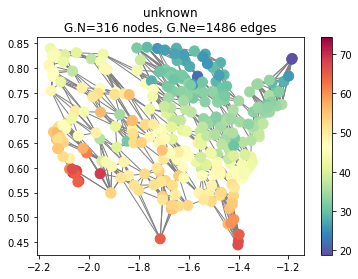

In [3]:
npzfile = np.load(DATASET_PATH)
A = npzfile['A']
A_bin = npzfile['A_bin']
X = npzfile['X']
Coords = npzfile['Coords']
n_signals = np.min([X.shape[1], MAX_SIGNALS])

G = Graph(A)
G.set_coordinates(Coords)
G.plot_signal(X[:, 31])
S = A
L = G.L.todense()


## Set the expetiments

In [4]:
N_P = [.3]

lr = 0.001
epochs = 100
lr = 0.001

Exps = [
        # CVX methods
        {'type': 'BL', 'S': A, 'alpha': .1, 'legend': 'BL'},
        {'type': 'TV', 'A': A, 'alpha': 1, 'legend': 'TV'},
        {'type': 'LR', 'L': L, 'alpha': 15, 'legend': 'LR'},
        {'type': 'GTF', 'A': A, 'k': 3, 'lamb': .5, 'legend': 'GTF'},

        # Non-convex
        {'type': 'MED', 'S': A, 'legend': 'MED'},
        {'type': 'GCNN', 'fts': 150, 'A': A, 'last_fts': 1, 'last_act': None, 'legend': 'GCNN'},
        {'type': 'GAT', 'fts': 70, 'A': A, 'heads': 3, 'legend': 'GAT'},
        {'type': 'KronAE', 'fts': 15, 'A': A, 'r': .5, 'legend': 'K-GAE'},

        # Our models
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [65]*3 + [1], 'bn': False,
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'H_norm': False,
         'legend': 'GCG'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [25, 50, 150] + [G.N]*2, 'fts': [50]*4 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
         'legend': 'GD'},
        ]

legend = [exp['legend'] for _, exp in enumerate(Exps)]

# Create filter H
h_params = {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.1, 'H_norm': False}
H = utils.create_filter(S, h_params)
H_norm = H/np.linalg.norm(H)

# Compute needed matrices
for exp in Exps:
    if exp['type'] == '2LD':
        exp['H'] = H_norm if exp['H_norm'] else H
    elif exp['type'] == 'DD' and exp['ups'] is Ups.U_MEAN:
        clt = MultiResGraphClustering(G, exp['nodes'], exp['nodes'][0])
        exp['nodes'] = clt.sizes
        exp['Us'] = clt.Us
        exp['As'] = clt.As
    elif exp['type'] == 'DD' and exp['ups'] is Ups.U_MAT:
        exp['Us'] = [H_norm] if exp['H_norm'] else [H]
        exp['Us'] = exp['Us']*(len(exp['nodes'])-2) + [None] 
        exp['As'] = []

## Using Gaussian noise

In [5]:
err = np.zeros((len(N_P), n_signals, len(Exps), epochs))
weights = np.zeros(len(Exps))
start_time = time.time()
for i, n_p in enumerate(N_P):
    print('Noise:', n_p)
    for j in range(n_signals):
        x = X[:, j]
        x /= np.linalg.norm(x)
        x_n = ds.GraphSignal.add_noise(x, n_p, n_type='gaussian')
    
        for k, exp in enumerate(Exps):
            model = select_model(exp, x_n, epochs, lr, device)

            if type(model) == Model:
                weights[k] = model.count_params()
                _, err[i, j, k], _ = model.fit(x_n, x, device=device)
            else:
                model.fit(x_n)
                _, err_non_train = model.test(x)
                err[i, j, k] = np.repeat(err_non_train, epochs)

        print(j, end=' ')
    print()

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

Noise: 0.3
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 

--- 4.0389593005180355 minutes ---


### Plot results

In [6]:
best_mean_err, _, _, _ = get_best_err(err)
print_err(best_mean_err, weights)

N_P: [0.3]
BL (0.0): 	0.0608
TV (0.0): 	0.1157
LR (0.0): 	0.0937
GTF (0.0): 	0.0636
MED (0.0): 	0.0529
GCNN (23101.0): 	0.1177
GAT (16101.0): 	0.0471
K-GAE (526.0): 	0.1418
GCG (8515.0): 	0.0549
GD (7550.0): 	0.0347


## Using Uniform noise

In [7]:
err2 = np.zeros((len(N_P), n_signals, len(Exps), epochs))
weights2 = np.zeros(len(Exps))
start_time = time.time()
for i, n_p in enumerate(N_P):
    print('Noise:', n_p)
    for j in range(n_signals):
        x = X[:, j]
        x /= np.linalg.norm(x)
        x_n = ds.GraphSignal.add_noise(x, n_p, n_type='gaussian')
    
        for k, exp in enumerate(Exps):
            model = select_model(exp, x_n, epochs, lr, device)

            if type(model) == Model:
                weights2[k] = model.count_params()
                _, err2[i, j, k], _ = model.fit(x_n, x, device=device)
            else:
                model.fit(x_n)
                _, err_non_train = model.test(x)
                err2[i, j, k] = np.repeat(err_non_train, epochs)

        print(j, end=' ')
    print()

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

Noise: 0.3
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 

--- 3.8777886668841046 minutes ---


### Plot results

In [8]:
best_mean_err, _, _, _ = get_best_err(err2)
print_err(best_mean_err, weights2)

N_P: [0.3]
BL (0.0): 	0.0623
TV (0.0): 	0.1164
LR (0.0): 	0.0956
GTF (0.0): 	0.0666
MED (0.0): 	0.0534
GCNN (23101.0): 	0.1240
GAT (16101.0): 	0.0482
K-GAE (526.0): 	0.1344
GCG (8515.0): 	0.0567
GD (7550.0): 	0.0351


In [9]:
# if False:
#     data = {
#         'seed': SEED,
#         'MAX_SIGNALS': MAX_SIGNALS,
#         'N_P': N_P,
#         'exps': Exps,
#         'err': err,
#         'err2': err2,
#         'h_params': h_params,
#         'lr': lr,
#         'weights': weights,
#         'weights2': weights2,
#         'legend': legend,
#         'fmts': [],
#     }
#     utils.save_results('temps_baselines', PATH, data)
    

In [10]:
# # LOAD
# file = '../results/temperatures/denoise_2021_06_14-19_11.npy'
# data = np.load(file,allow_pickle=True).item()
# err = data['err']
# Exps = data['exps']
# N_P = data['N_P']
# SEED = data['seed']
# h_params = data['h_params']
# lr = data['lr']
# weights = data['weights']

# median_err = np.median(err, axis=1)

In [11]:
plt.show()